In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH1_PATH = "/content/drive/MyDrive/planet_batches/batch_0.npz"
BATCH2_PATH = "/content/drive/MyDrive/planet_batches/batch_1.npz"

KEY = "X"

In [ ]:
batch1 = np.load(BATCH1_PATH)[KEY]
batch2 = np.load(BATCH2_PATH)[KEY]

print("Batch 1:", batch1.shape)
print("Batch 2:", batch2.shape)

Batch 1: (4, 1)
Batch 2: (4, 1)


In [ ]:
print(f"Keys in batch_0.npz: {np.load(BATCH1_PATH).files}")
print(f"Keys in batch_1.npz: {np.load(BATCH2_PATH).files}")

Keys in batch_0.npz: ['X', 'y']
Keys in batch_1.npz: ['X', 'y']


In [ ]:
X = np.concatenate([batch1.flatten(), batch2.flatten()], axis=0).reshape(1, -1).astype(np.float32)
print("Total planet light curves:", X.shape)

Total planet light curves: (1, 8)


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/exoplanet_data/exoplanet_data.npy"
np.save(SAVE_PATH, X)

In [ ]:
class PlanetLightCurveDataset(Dataset):
    def __init__(self, npy_path):
        self.data = np.load(npy_path).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return torch.from_numpy(x).unsqueeze(0)


In [ ]:
dataset = PlanetLightCurveDataset(SAVE_PATH)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
sample = dataset[0]
print(sample.shape)

torch.Size([1, 8])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_length = dataset[0].shape[-1]
model = PlanetAutoencoder(input_length).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
class PlanetAutoencoder(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        # Encoder learns transit morphology
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 7, stride=2, padding=3),
            nn.ReLU(),

            nn.Conv1d(16, 32, 7, stride=2, padding=3),
            nn.ReLU(),

            nn.Conv1d(32, 64, 7, stride=2, padding=3),
            nn.ReLU()
        )

        # Decoder reconstructs planet light curves
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 16, 7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 1, 7, stride=2, padding=3, output_padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_length = dataset[0].shape[-1]
model = PlanetAutoencoder(input_length).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{EPOCHS}]  Reconstruction Loss: {avg_loss:.6f}")

Epoch [1/50]  Reconstruction Loss: 1.207836
Epoch [2/50]  Reconstruction Loss: 1.193262
Epoch [3/50]  Reconstruction Loss: 1.178283
Epoch [4/50]  Reconstruction Loss: 1.163038
Epoch [5/50]  Reconstruction Loss: 1.147074
Epoch [6/50]  Reconstruction Loss: 1.130293
Epoch [7/50]  Reconstruction Loss: 1.112432
Epoch [8/50]  Reconstruction Loss: 1.093193
Epoch [9/50]  Reconstruction Loss: 1.072867
Epoch [10/50]  Reconstruction Loss: 1.050468
Epoch [11/50]  Reconstruction Loss: 1.025657
Epoch [12/50]  Reconstruction Loss: 0.998079
Epoch [13/50]  Reconstruction Loss: 0.967311
Epoch [14/50]  Reconstruction Loss: 0.932834
Epoch [15/50]  Reconstruction Loss: 0.894459
Epoch [16/50]  Reconstruction Loss: 0.851277
Epoch [17/50]  Reconstruction Loss: 0.802956
Epoch [18/50]  Reconstruction Loss: 0.749026
Epoch [19/50]  Reconstruction Loss: 0.689532
Epoch [20/50]  Reconstruction Loss: 0.623992
Epoch [21/50]  Reconstruction Loss: 0.551874
Epoch [22/50]  Reconstruction Loss: 0.475177
Epoch [23/50]  Reco

In [ ]:
def planet_reconstruction_error(model, x):
    model.eval()
    with torch.no_grad():
        recon = model(x)
        error = torch.mean((x - recon) ** 2, dim=[1, 2])
    return error


In [ ]:
sample = dataset[0].unsqueeze(0).to(device)
error = planet_reconstruction_error(model, sample)
print("Planet reconstruction error:", error.item())

Planet reconstruction error: 0.005593759473413229


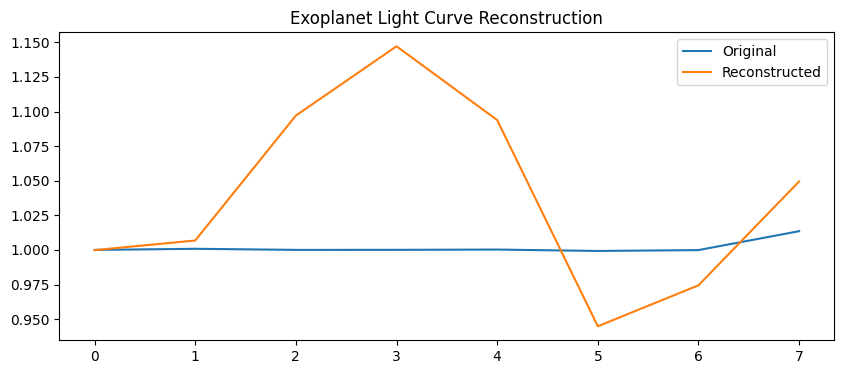

In [ ]:
model.eval()
with torch.no_grad():
    recon = model(sample).cpu().squeeze().numpy()
    original = sample.cpu().squeeze().numpy()

plt.figure(figsize=(10,4))
plt.plot(original, label="Original")
plt.plot(recon, label="Reconstructed")
plt.legend()
plt.title("Exoplanet Light Curve Reconstruction")
plt.show()

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/exoplanet_data/planet_autoencoder.pt"
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/exoplanet_data/planet_autoencoder.pt"
torch.save(model.state_dict(), MODEL_PATH)